This notebook is a plementation of deep learning. The data is pneumonia medical images with boxes bounding the sceptical regions. The target of the challenge is to draw the boxes. I start with a classification problem which is to divide images into 2 groups: either having disease or being normal. 

The images are saved as \*.dcm files. So we need pydicom package to read and process them. Our data contains one \*.csv having ID of patients and class. Patients are divided in 3 classes: Normal, Not normal but No Lung Opacity,  and Lung Opacity where the two first ones are no disease and the last is disease. So the first task that I will do is to label patients to be either 0 for being healthy or 1 for sick. At fisrt task, I ignore the boxes and leave it for later stage.

In [6]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

In [2]:
!ls ../Data/all/

GCP Credits Request Link - RSNA.txt  stage_2_test_images.zip
stage_2_detailed_class_info.csv      stage_2_train_images
stage_2_sample_submission.csv	     stage_2_train_images.zip
stage_2_test_images		     stage_2_train_labels.csv


In [8]:
info_dir='stage_2_detailed_class_info.csv'
image_dir='stage_2_train_images'

In [311]:
df1 = pd.read_csv('../Data/all/'+info_dir)
df1.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [317]:
df1['class'][0]

'No Lung Opacity / Not Normal'

In [10]:
df=df.replace(["No Lung Opacity / Not Normal","Normal"],0)
df=df.replace(["Lung Opacity"],1)
df.rename(columns={'class': 'Target'},inplace=True)
df.head()

patientId  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0
2  00322d4d-1c29-4943-afc9-b6754be640eb       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0
4  00436515-870c-4b36-a041-de91049b9ab4       1

Let's show one image.

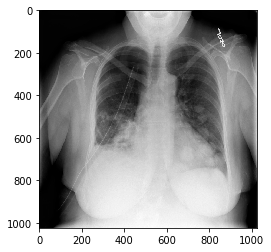

In [8]:
patient0=df.patientId[0]
patient0_file='../Data/all/'+image_dir+'/%s.dcm' % patient0
image0_data = pydicom.read_file(patient0_file)
image0 = image0_data.pixel_array
pylab.imshow(image0, cmap=pylab.cm.gist_gray)

The image is of lungs captured from front. I've done a small descriptive analysis here.  

I would like to load and process data in order to prepare for training a neural network. I start with the simplest process where there is neither transfromation nor augemetation to data. Then a simple model is implemented with only 4 training samples and one validating one. It reduces training time so help us to test our codes effectively.

In [11]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader

In [12]:
class PneuDataset(Dataset):
    """Pneunomia dataset."""

    def __init__(self, FileName_data, img_dir, transform=None):
        """
        Args:
            FileName_data: Data frame with filenames of images.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = FileName_data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient=self.df.patientId[idx]
        patient_file = os.path.join(self.img_dir,patient)+'.dcm'
        image = pydicom.read_file(patient_file).pixel_array
        label=self.df.Target[idx]
        
        if self.transform:
            image=self.transform(image)
        
        image = np.expand_dims(image, axis=0)
        
        return image, label

The following function is used to check accuracy on validation set. It simply calculates the rate of correct predition over total validation test.

In [40]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f), and loss %.4f' % (num_correct, num_samples, 100 * acc, loss.item()))

In [18]:
import torch.nn.functional as F

In [332]:
def train(model, optimizer, epochs=1):
    """
    Train a model.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
  
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t+e*len(loader_train)) % print_every == 0:
                print('Iteration %d, epoch %d, loss = %.4f' % (t, e, loss.item()))
                check_accuracy(loader_val, model)
                print()

Now let's train the first model which contains only 2 convolutional layers with ReLU activation and a fully connected net at the last layer. We can play with all parameters like channels, sizes of convolution,...

In [19]:
# try a simple model
import torch.nn as nn

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

    
channel_1 = 32
channel_2 = 16

model0=nn.Sequential(
    nn.Conv2d(1,channel_1, 7,padding=3),
    nn.ReLU(),
    nn.Conv2d(channel_1,channel_2,3,padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2*1024*1024,2),
)

I load only 5 samples then divide them into 4-sample training set and one-sample validation set.

In [42]:
FileName_100=df[:10]
img_dir_1='../Data/all/'+image_dir
dataset_1=PneuDataset(FileName_data=FileName_100, img_dir=img_dir_1)
#dataloader = DataLoader(dataset_1, batch_size=1,
#                        shuffle=True)


In [12]:
image0,label=dataset_1[1]
#pylab.imshow(image0, cmap=pylab.cm.gist_gray)
print('label', label)
print('size_image', image0.shape)

label 0
size_image (1, 1024, 1024)


In [43]:
train_size = 8
val_size = 2
train_dataset, val_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size])

loader_train = DataLoader(train_dataset, batch_size=1,
                        shuffle=True)

loader_val = DataLoader(val_dataset, batch_size=1,
                        shuffle=True)

We are ready to train our model. Here it is:

In [44]:
import torch.optim as optim
device = torch.device('cuda')
dtype = torch.float32 
    
learning_rate = 0.7e-4
print_every=3

optimizer = optim.SGD(model0.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model0, optimizer,epochs=3)

Iteration 0, epoch 0, loss = 37008.3203
Got 0 / 2 correct (0.00), and loss 1410870272.0000

Iteration 3, epoch 0, loss = 0.0000
Got 1 / 2 correct (50.00), and loss 0.7030

Iteration 6, epoch 0, loss = 0.6930
Got 2 / 2 correct (100.00), and loss 0.5998

Iteration 0, epoch 1, loss = 0.6570
Got 1 / 2 correct (50.00), and loss 0.0059

Iteration 3, epoch 1, loss = 0.0000
Got 1 / 2 correct (50.00), and loss 11.9424

Iteration 6, epoch 1, loss = 0.0000
Got 1 / 2 correct (50.00), and loss 0.0000

Iteration 0, epoch 2, loss = 0.0000
Got 0 / 2 correct (0.00), and loss 79129.3750

Iteration 3, epoch 2, loss = 0.0000
Got 0 / 2 correct (0.00), and loss 7151291.0000

Iteration 6, epoch 2, loss = 0.6922
Got 0 / 2 correct (0.00), and loss 1427054.0000



I will implement a transformation to dataset and re-train the model above. I implement only two transformation: a resizing, flipping, and their combination. 

In [23]:
from skimage import io, transform

#Transform an image
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        if isinstance(self.output_size, int):
            new_h, new_w=self.output_size, self.output_size 
        else:
            new_h, new_w = self.output_size

        img = transform.resize(image, (new_h, new_w))

        return img

class Flip(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        image = np.fliplr(image)
        return image
    

/home/minh/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


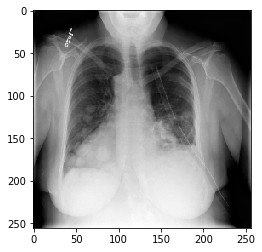

In [26]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")

scale=Rescale(256)
flip=Flip()
composed = transforms.Compose([scale, flip])
fig = plt.figure()
sample,_ = train_dataset[0]
sample=sample.reshape((1024,1024))
sample.shape
pylab.imshow(sample, cmap=pylab.cm.gist_gray)
image_scaled=composed(sample)
pylab.imshow(image_scaled, cmap=pylab.cm.gist_gray)

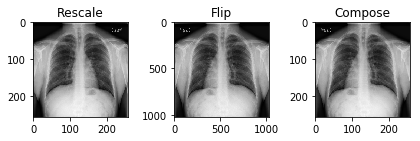

In [90]:
fig = plt.figure()

for i, tsfrm in enumerate([scale, flip, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    pylab.imshow(transformed_sample,cmap=pylab.cm.gist_gray)    


In [45]:
dataset_transformed=PneuDataset(FileName_data=FileName_100, img_dir=img_dir_1, transform=scale)

In [20]:
image0,label=dataset_transformed[0]
#pylab.imshow(image0, cmap=pylab.cm.gist_gray)
print('label', label)
print('size_image', image0.shape)

label 0
size_image (1, 256, 256)


In [46]:
channel_1 = 32
channel_2 = 16

model1=nn.Sequential(
    nn.Conv2d(1,channel_1, 5,padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1,channel_2,3,padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2*256*256,2),
)

train_dataset1, val_dataset1 = torch.utils.data.random_split(dataset_transformed, [train_size, val_size])

loader_train = DataLoader(train_dataset1, batch_size=1,
                        shuffle=True)

loader_val = DataLoader(val_dataset1, batch_size=1,
                        shuffle=True)

In [47]:
learning_rate = 1e-2
print_every=3

optimizer = optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model1, optimizer,epochs=5)

Iteration 0, epoch 0, loss = 0.6435
Got 2 / 2 correct (100.00), and loss 0.0000

Iteration 3, epoch 0, loss = 483.9541
Got 2 / 2 correct (100.00), and loss 0.0000

Iteration 6, epoch 0, loss = 0.6477
Got 0 / 2 correct (0.00), and loss 0.7593

Iteration 0, epoch 1, loss = 0.7606
Got 0 / 2 correct (0.00), and loss 0.7557

Iteration 3, epoch 1, loss = 0.6571
Got 0 / 2 correct (0.00), and loss 0.7311

Iteration 6, epoch 1, loss = 0.7517
Got 0 / 2 correct (0.00), and loss 0.7456

Iteration 0, epoch 2, loss = 0.7569
Got 0 / 2 correct (0.00), and loss 0.7501

Iteration 3, epoch 2, loss = 0.7529
Got 0 / 2 correct (0.00), and loss 0.7381

Iteration 6, epoch 2, loss = 0.6365
Got 0 / 2 correct (0.00), and loss 0.7674

Iteration 0, epoch 3, loss = 0.7629
Got 0 / 2 correct (0.00), and loss 0.7530

Iteration 3, epoch 3, loss = 0.7183
Got 2 / 2 correct (100.00), and loss 0.6824

Iteration 6, epoch 3, loss = 0.6900
Got 0 / 2 correct (0.00), and loss 0.7051

Iteration 0, epoch 4, loss = 0.6710
Got 0 / 

I will load one pretrained model and modify some layers, then train the modified model. I choose the squeezenet because of its simpleness. 

In [32]:
import torchvision.models as models

squeezenet = models.squeezenet1_0()

I would like to check all layers of the SqueezeNet. So I print each layer out.

In [105]:
child_counter = 0
for child in squeezenet.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation):

SqueezeNet reduces the number of parameters by two techniques: replace big convolution by $1\times 1$ convolution layers which is called squeeze step; reduce the number of channels corresponding to the big convolution. For the tradeoff issue complexity-accuracy, it says that if we reduce the complexity we pay by also reduce the accuracy. So to maintain the accuracy they postpone the downsample late in the network. 

So instead of using a conventional convolution layer, for example $3\times 3$-size, they replace it by a so called fire layer consisting of one queezed stage and one expanded stage, the squeezing reduces the number of input channels, and the expanding recovers the output channel but by two blocks, one with $1\times 1$ convolution and the rest with $3 \times 3$. 

Let's look at one layer to illustrate for the above analysis. If we, for example, use a $3\times 3$ convolution layer to treat the input $55\times 55\times 96$ with the output $55\times 55\times 128$ we have $(3\times 3\times 3\times 96+1)\times 128 = 110720$ parameters. Now we first use a $1\times 1$ convolution to reduce the input channel 96 down to 16, then a $1\times 1$ one to cover 96 output channels and a $3\times 3$ one to complement the rest 96 output channels, we finally get the same dimention output, but the number of parameters is $(1\times 1\times 96+1)\times 16+(1\times 1\times 16+1)\times 64+(3\times 3\times 16+1)\times 64=11920$, 9 times smaller.

So as listed, SqueezeNet is:
convolution -> MaxPool -> (fire) $\times 3$ -> Maxpool -> (fire) $\times 4$ -> MaxPool -> fire -> Dropout -> convolution -> AvgPool

Now I would like to adopt SqueezeNet to my problem. I start with the smallest modification: input channel of the first layer. Because my image is not BRG but only one channel. I will also resize image to $224\times 224$ and add one fully connected layer to get 2 scores since we have only 2 classes.

In [357]:
conv1=nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
child0=list(squeezenet.children())[0]
fire=child0[1:]
child1=list(squeezenet.children())[1]
child11=child1[1:-1]

model_modified=nn.Sequential(
    conv1,
    fire,
    child11,
    nn.Conv2d(1000, 96, kernel_size=(1, 1), stride=(1, 1)),
    Flatten(),
    nn.Linear(13*13*96,2)
    )

Let's check again our model's architecture.

In [60]:
child_counter = 0
for child in model_modified.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
 child 1 is:
Sequential(
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activa

In [ ]:
torch.save(model, 'squeezeNetModified.pt')

And then check model with only one sample.

In [322]:
FileName_1=df.iloc[[0,1,4,5]]
FileName_1.index=np.arange(4)
#FileName_1=pd.DataFrame(FileName, index=range(3))
dataset_transformed=PneuDataset(FileName_data=FileName_1, img_dir=img_dir_1, transform=Rescale(224))

# train_dataset1, val_dataset1 = torch.utils.data.random_split(dataset_transformed, [train_size, val_size])

loader_train = DataLoader(dataset_transformed, batch_size=4,
                        shuffle=True)

loader_val=loader_train

# loader_val = DataLoader(val_dataset1, batch_size=1,
#                         shuffle=True)

# loader = DataLoader(dataset_transformed, batch_size=1,
#                         shuffle=True)
# loader_train=loader
# loader_val = loader
FileName_1

patientId  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0
2  00436515-870c-4b36-a041-de91049b9ab4       1
3  00436515-870c-4b36-a041-de91049b9ab4       1

In [329]:
learning_rate = 1e-3
print_every=1000

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        
model_modified.apply(weights_init)

optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=10000)

Iteration 0, epoch 0, loss = 0.6932
Got 2 / 4 correct (50.00), and loss 0.6932

Iteration 0, epoch 1000, loss = 0.6931
Got 4 / 4 correct (100.00), and loss 0.6931

Iteration 0, epoch 2000, loss = 0.6931
Got 3 / 4 correct (75.00), and loss 0.6931

Iteration 0, epoch 3000, loss = 0.6931
Got 4 / 4 correct (100.00), and loss 0.6931

Iteration 0, epoch 4000, loss = 0.6931
Got 4 / 4 correct (100.00), and loss 0.6931

Iteration 0, epoch 5000, loss = 0.6931
Got 4 / 4 correct (100.00), and loss 0.6931

Iteration 0, epoch 6000, loss = 0.6931
Got 2 / 4 correct (50.00), and loss 0.6931

Iteration 0, epoch 7000, loss = 0.6931
Got 3 / 4 correct (75.00), and loss 0.6931

Iteration 0, epoch 8000, loss = 0.6931
Got 3 / 4 correct (75.00), and loss 0.6931

Iteration 0, epoch 9000, loss = 0.6931
Got 4 / 4 correct (100.00), and loss 0.6931



I will train the new model with a bigger sample. Let's check 500 samples with 400 training ones and 100 for validation.

In [330]:
FileName_500=df[:500]

dataset_transformed=PneuDataset(FileName_data=FileName_500, img_dir=img_dir_1, transform=Rescale(224))

train_size = 400
val_size = 100

train_dataset_500, val_dataset_500 = torch.utils.data.random_split(dataset_transformed, [train_size, val_size])

loader_train = DataLoader(train_dataset_500, batch_size=4,
                        shuffle=True)

loader_val = DataLoader(val_dataset_500, batch_size=4,
                        shuffle=True)

In [355]:
t=[train_dataset_500[i][1] for i in range(len(train_dataset_500))]

In [356]:
sum(t)

180

In [358]:
device='cuda'
learning_rate = 1e-3
print_every=100

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=100)

Iteration 0, epoch 0, loss = 0.6932
Got 55 / 100 correct (55.00), and loss 0.6932

Iteration 0, epoch 1, loss = 0.6963
Got 55 / 100 correct (55.00), and loss 0.6567

Iteration 0, epoch 2, loss = 0.7183
Got 55 / 100 correct (55.00), and loss 0.6714

Iteration 0, epoch 3, loss = 0.6967
Got 55 / 100 correct (55.00), and loss 0.7392

Iteration 0, epoch 4, loss = 0.7157
Got 55 / 100 correct (55.00), and loss 0.7160

Iteration 0, epoch 5, loss = 0.6986
Got 55 / 100 correct (55.00), and loss 0.7513

Iteration 0, epoch 6, loss = 0.6492
Got 55 / 100 correct (55.00), and loss 0.6004

Iteration 0, epoch 7, loss = 0.6241
Got 55 / 100 correct (55.00), and loss 0.6960

Iteration 0, epoch 8, loss = 0.6088
Got 55 / 100 correct (55.00), and loss 0.6520

Iteration 0, epoch 9, loss = 0.7432
Got 55 / 100 correct (55.00), and loss 0.6973

Iteration 0, epoch 10, loss = 0.6977
Got 55 / 100 correct (55.00), and loss 0.6977

Iteration 0, epoch 11, loss = 0.6209
Got 55 / 100 correct (55.00), and loss 0.6961

It

Iteration 0, epoch 98, loss = 0.6472
Got 55 / 100 correct (55.00), and loss 0.6984

Iteration 0, epoch 99, loss = 0.5979
Got 55 / 100 correct (55.00), and loss 0.7995



After training, I notice that our model seems not to work well. I suppose our medical images are too similar so we may need a more complex model. Let's check the model with dog-cat images to see if it works.

I downlad some cat/dog images and I will write a new loader function. Let's first show one image. Since our model's input is two dimention image, I will transform the original RBG image to gray scale. 

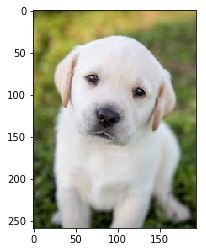

(259, 194, 3)
(259, 194)


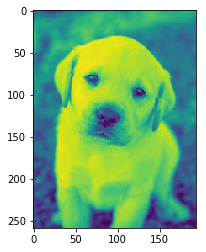

In [152]:
import matplotlib.image as mpimg
img=mpimg.imread('../Data/all/dog_cat/train/dog/download.jpeg')
imgplot = plt.imshow(img)
plt.show()
print(img.shape)
from PIL import Image
img = Image.open('../Data/all/dog_cat/train/dog/download.jpeg')
img_gray = img.convert('LA')
img = np.array(list(img_gray.getdata(band=0)), float)
img.shape = (img_gray.size[1], img_gray.size[0])
plt.imshow(img)
print(img.shape)

In [96]:
dir_animal='../Data/all/dog_cat/train'
classes=[d for d in os.listdir(dir_animal) if os.path.isdir(os.path.join(dir_animal,d))]
classes.sort()
class_to_idx={classes[i]:i for i in range(len(classes))}
              
                
def make_dataset(dir, class_to_idx):
    images=[]
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for fname in sorted(os.listdir(d)):
            if fname.endswith('.jpeg'):
                path = os.path.join(d, fname)
                item = (path, class_to_idx[target])
                images.append(item)

    return images

              
data_animal=make_dataset(dir_animal, class_to_idx)

len(data_animal)
i=data_animal[0]
i[1]

0

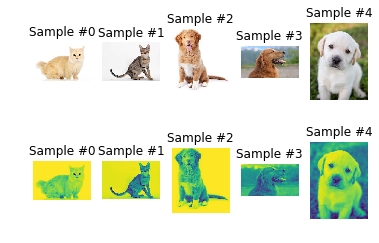

In [126]:
fig=plt.figure()

for i in range(len(data_animal)):
    sample=data_animal[i]
    file_img=sample[0]
    
    img=mpimg.imread(file_img)

    ax=plt.subplot(2,5,i+1)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    imgplot = plt.imshow(img)
    
    
    img = Image.open(file_img)
    img_gray = img.convert('LA')
    img = np.array(list(img_gray.getdata(band=0)), float)
    img.shape = (img_gray.size[1], img_gray.size[0])
    ax=plt.subplot(2,5,i+6)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    plt.imshow(img)
    

plt.show()
    

In [159]:
class DatasetFolder(Dataset):
    """A generic data loader where the samples are arranged in this way: ::

        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext

        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext

    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.

     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
    """

    def __init__(self, dir, transform=None):
        samples = make_dataset(dir, class_to_idx)
 
        self.dir = dir
        self.class_to_idx = class_to_idx
        self.samples = samples

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, label = self.samples[index]
        img = Image.open(path)
        img_gray = img.convert('LA')
        img = np.array(list(img_gray.getdata(band=0)), float)
        img.shape = (img_gray.size[1], img_gray.size[0])
         
        if self.transform is not None:
            img = self.transform(img)

        img = np.expand_dims(img, axis=0)
        return img, label


    def __len__(self):
        return len(self.samples)



In [160]:
data_animal=DatasetFolder(dir_animal, transform=Rescale(224))
len(data_animal)
img0=data_animal[0]
print(img0[0].shape)


(1, 224, 224)


In [196]:
train_size=4
val_size=1
train_dataset1, val_dataset1 = torch.utils.data.random_split(data_animal, [train_size, val_size])

loader_train = DataLoader(train_dataset1, batch_size=4,
                        shuffle=True)

loader_val=loader_train

# loader_val = DataLoader(val_dataset1, batch_size=1,
#                         shuffle=True)

In [213]:
learning_rate = 0.1e-3
print_every=10

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         torch.nn.init.xavier_uniform(m.weight.data)
        
# model_modified.apply(weights_init)


optimizer = optim.SGD(model_modified.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model_modified, optimizer,epochs=40)

Iteration 0, epoch 0, loss = 0.0659
Got 4 / 4 correct (100.00), and loss 0.0658

Iteration 0, epoch 1, loss = 0.0658
Got 4 / 4 correct (100.00), and loss 0.0655

Iteration 0, epoch 2, loss = 0.0655
Got 4 / 4 correct (100.00), and loss 0.0653

Iteration 0, epoch 3, loss = 0.0653
Got 4 / 4 correct (100.00), and loss 0.0651

Iteration 0, epoch 4, loss = 0.0651
Got 4 / 4 correct (100.00), and loss 0.0648

Iteration 0, epoch 5, loss = 0.0648
Got 4 / 4 correct (100.00), and loss 0.0645

Iteration 0, epoch 6, loss = 0.0645
Got 4 / 4 correct (100.00), and loss 0.0642

Iteration 0, epoch 7, loss = 0.0642
Got 4 / 4 correct (100.00), and loss 0.0638

Iteration 0, epoch 8, loss = 0.0638
Got 4 / 4 correct (100.00), and loss 0.0634

Iteration 0, epoch 9, loss = 0.0634
Got 4 / 4 correct (100.00), and loss 0.0630

Iteration 0, epoch 10, loss = 0.0630
Got 4 / 4 correct (100.00), and loss 0.0627

Iteration 0, epoch 11, loss = 0.0627
Got 4 / 4 correct (100.00), and loss 0.0623

Iteration 0, epoch 12, los